In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import mode

from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder

import os
os.chdir("..")

import random
from tqdm import tqdm
from pathlib import Path
import numpy as np
import cv2
from joblib import Parallel, delayed, parallel_backend
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, cohen_kappa_score
from multiprocessing.dummy import Pool
import pandas as pd


from skin_lesion_cad.data.BOVW import DenseDescriptor, BagofWords, ColorDescriptor, LBPDescriptor, DescriptorsTransformer
from skin_lesion_cad.features.colour import ColorFeaturesDescriptor
from skin_lesion_cad.features.colour import ColorFeaturesExtractor
from skin_lesion_cad.features.texture import glcm_features
from skin_lesion_cad.features.texture import get_glcm, lbph

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Counter
from sklearn.base import TransformerMixin, BaseEstimator

import scipy


from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import fbeta_score, make_scorer

from skin_lesion_cad.data.ensemble import EnsemblingClssfifier, classifiers

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Final Validation Results for the Ensemble

/home/vzalevskyi/uni/MAIA_Semester_3/cad/skin-lesion-cad/skin_lesion_cad/data/ensemble.py:61: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.meta_model.fit(np.hstack(predicitons_proba.values()), y)
/home/vzalevskyi/uni/MAIA_Semester_3/cad/skin-lesion-cad/skin_lesion_cad/data/ensemble.py:90: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predictions['stacking'] = self.meta_model.predict(np.hstack(predicitons_proba.values()))
/home/vzalevskyi/uni/MAIA_Semester_3/cad/skin-lesion-cad/skin_lesion_cad/data/ensemble.py:91: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as ge

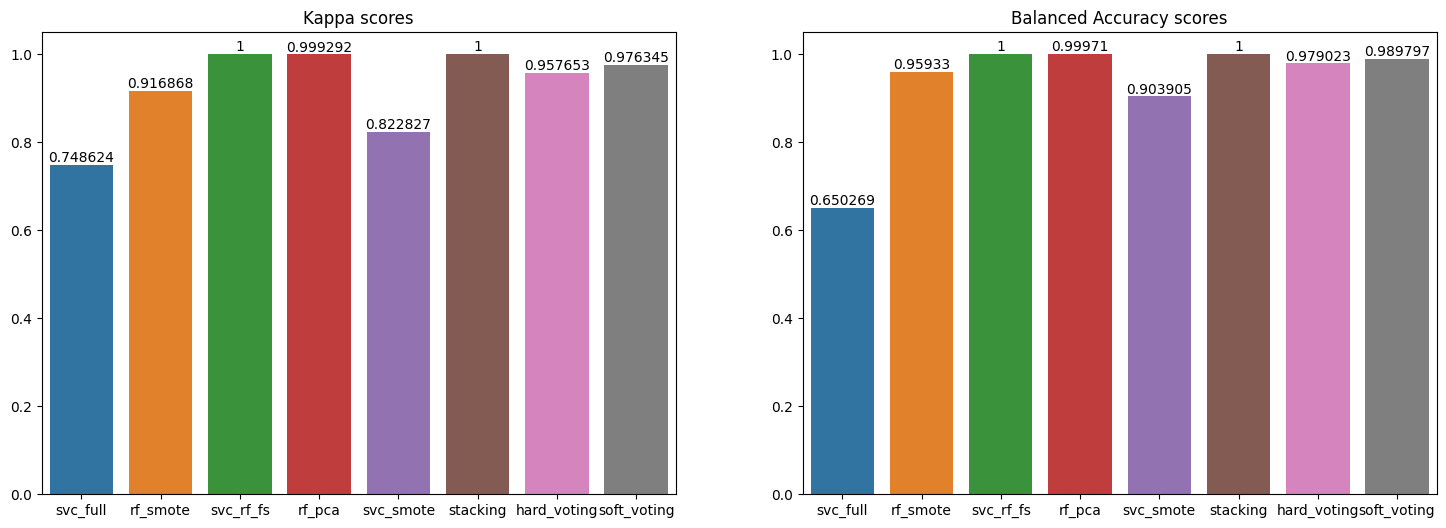

/home/vzalevskyi/uni/MAIA_Semester_3/cad/skin-lesion-cad/skin_lesion_cad/data/ensemble.py:90: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predictions['stacking'] = self.meta_model.predict(np.hstack(predicitons_proba.values()))
/home/vzalevskyi/uni/MAIA_Semester_3/cad/skin-lesion-cad/skin_lesion_cad/data/ensemble.py:91: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predicitons_proba['stacking'] = self.meta_model.predict_proba(np.hstack(predicitons_proba.values()))


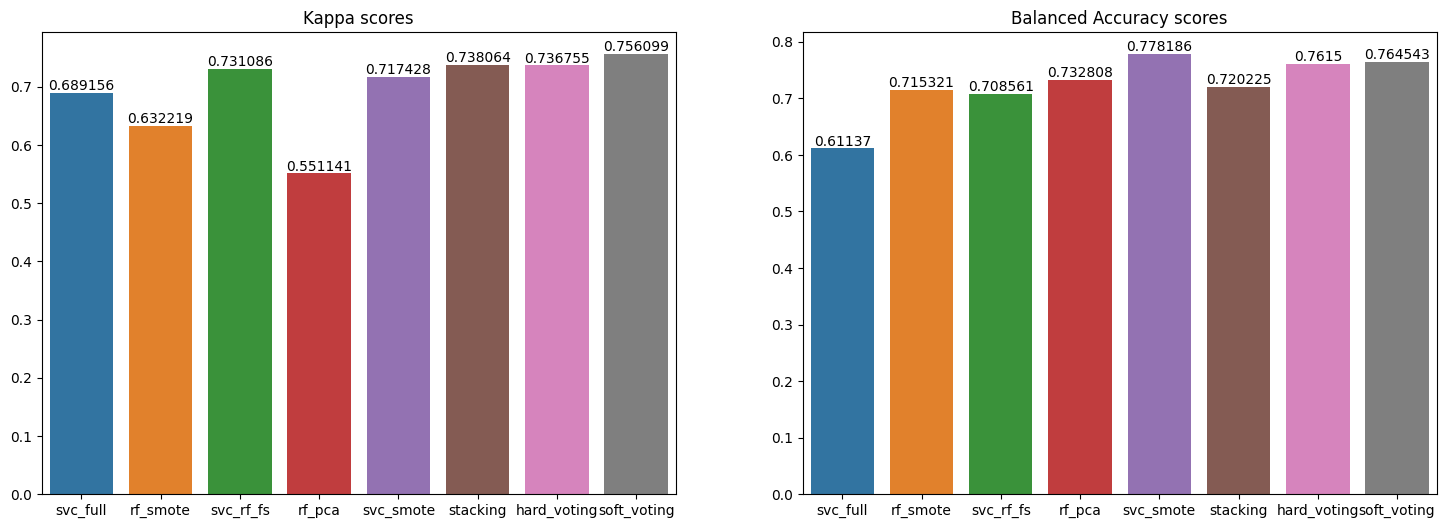

In [14]:
merged_df_TEST = pd.read_pickle('merged_df_TEST.pkl')
merged_df_val = pd.read_pickle('merged_df_val.pkl')
merged_df_train = pd.read_pickle('merged_df_train.pkl')


X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])
y_train = merged_df_train['class']
y_test = merged_df_val['class']


ens = EnsemblingClssfifier(classifiers, ['soft_voting', 'stacking', 'hard_voting'])

ens.fit(X_train.values, y_train.values, X_train.columns)
predictions, predicitons_proba = ens.predict(X_test.values, X_test.columns)
kappa_scores, balacc_scores = ens.evaluate(X_train.values, y_train.values, X_train.columns)
kappa_scores, balacc_scores = ens.evaluate(X_test.values, y_test.values, X_test.columns)

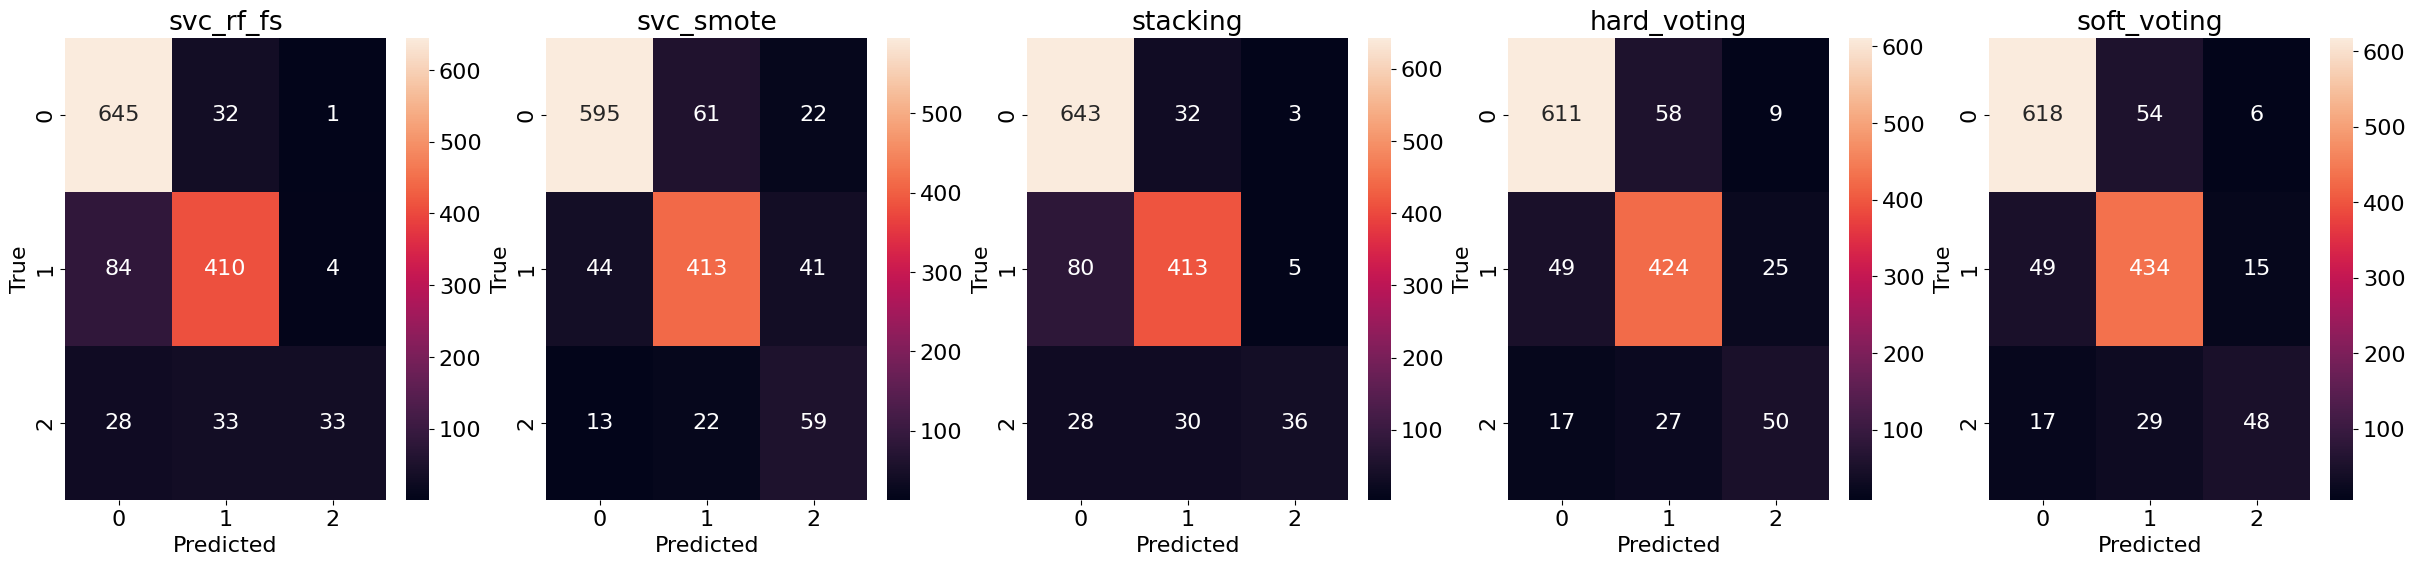

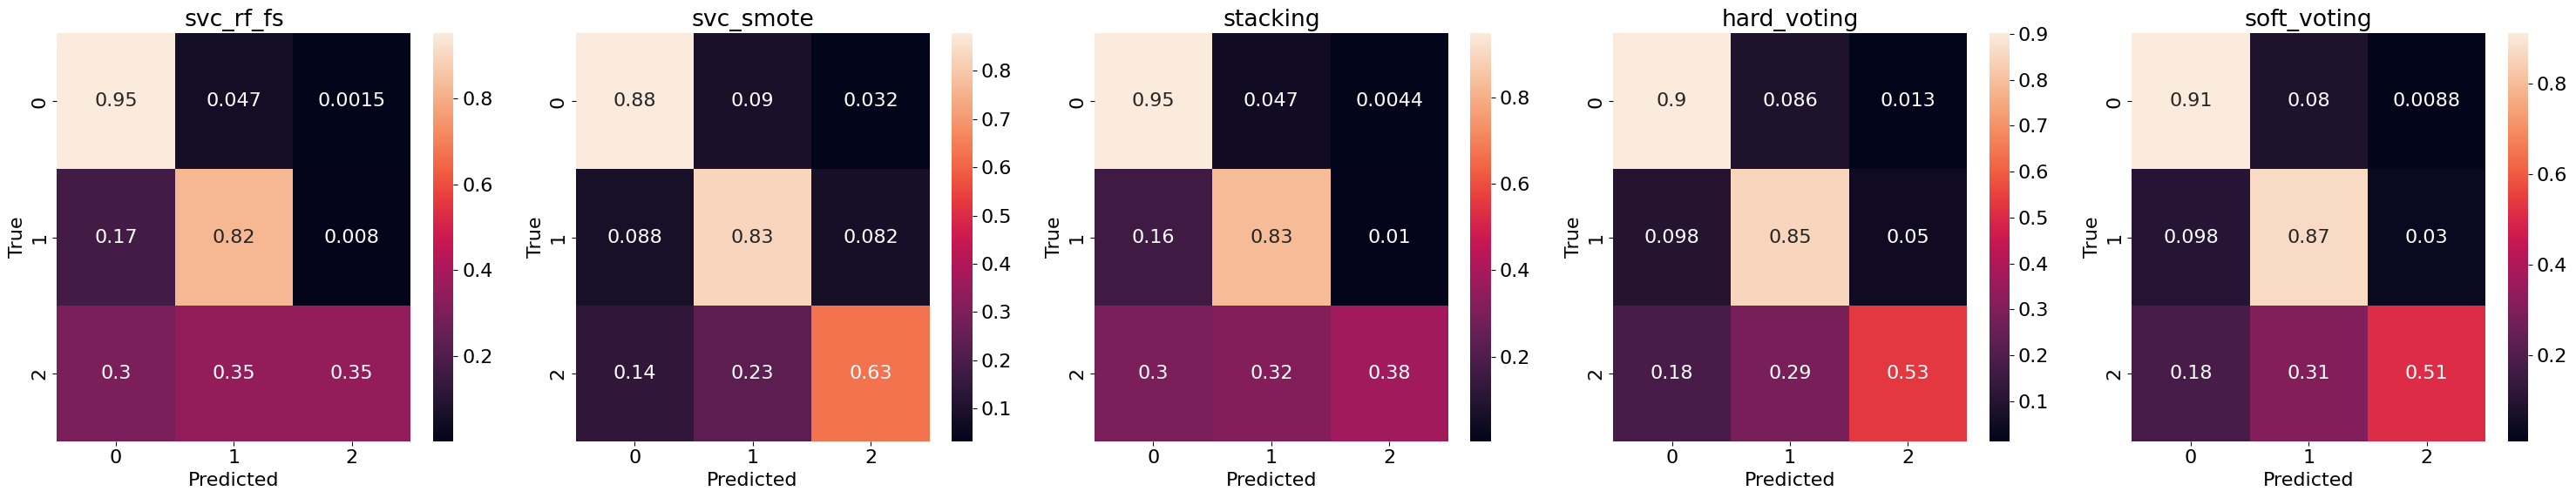

In [28]:
predictions = {k:v for k,v in predictions.items() if k in ['svc_smote', 'svc_rf_fs', 'stacking', 'hard_voting', 'soft_voting']}

fig, axs = plt.subplots(1, len(predictions), figsize=(30, 6))
plt.rcParams.update({'font.size': 16})

for i, (name, pred) in enumerate(predictions.items()):
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', ax=axs[i])
    axs[i].set_title(name)
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('True')
    
plt.show()

fig, axs = plt.subplots(1, len(predictions), figsize=(30, 6))
plt.rcParams.update({'font.size': 16})

for i, (name, pred) in enumerate(predictions.items()):
    sns.heatmap(confusion_matrix(y_test, pred, normalize='true'), annot=True, ax=axs[i], )
    axs[i].set_title(name)
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('True')
    

plt.tight_layout()
plt.show()

# FIANL TEST Predictions

In [3]:
merged_df_val = pd.read_pickle('merged_df_val.pkl')
merged_df_train = pd.read_pickle('merged_df_train.pkl')
merged_df_TEST = pd.read_pickle('merged_df_TEST.pkl')

merged_ALL = pd.concat([merged_df_train, merged_df_val])

X_train = merged_ALL.drop(columns=['class'])
X_test = merged_df_TEST
y_train = merged_ALL['class']


ens = EnsemblingClssfifier(classifiers, [])

ens.fit(X_train.values, y_train.values, X_train.columns)
predictions, predicitons_proba = ens.predict(X_test.values, X_test.columns)

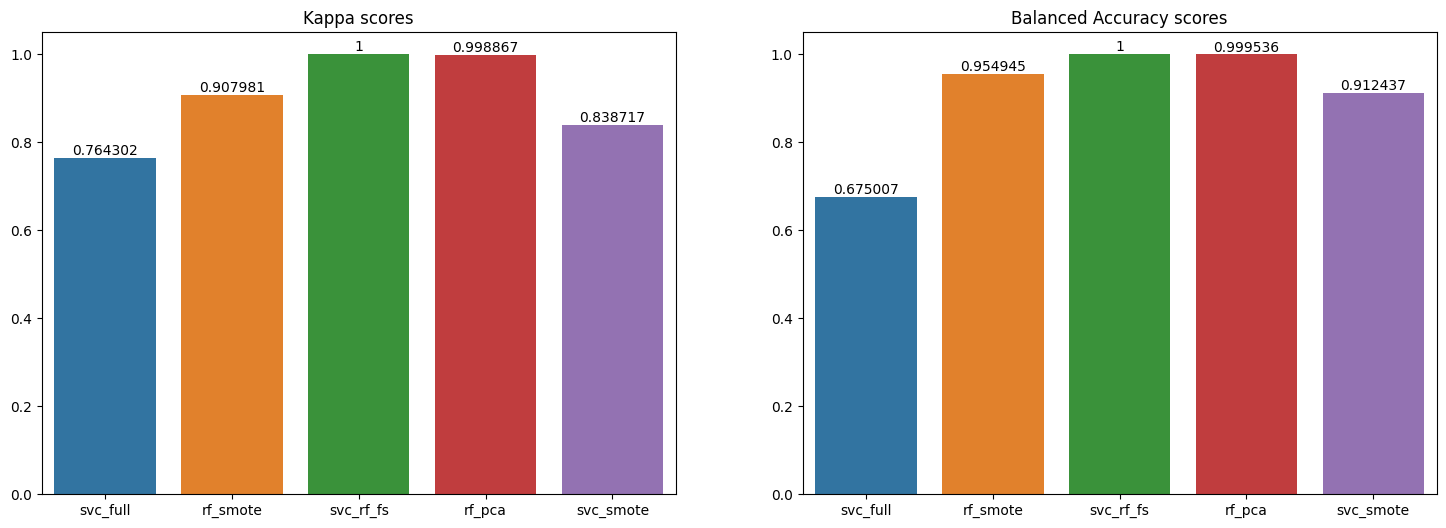

In [4]:
kappa_scores, balacc_scores = ens.evaluate(X_train.values, y_train.values, X_train.columns)

In [4]:
[(k, np.unique(predictions[k], return_counts=True)) for k in predictions.keys()]

[('svc_full', (array([0, 1, 2]), array([696, 567,   7]))),
 ('rf_smote', (array([0, 1, 2]), array([605, 518, 147]))),
 ('svc_rf_fs', (array([0, 1, 2]), array([757, 475,  38]))),
 ('rf_pca', (array([0, 1, 2]), array([561, 411, 298]))),
 ('svc_smote', (array([0, 1, 2]), array([652, 496, 122]))),
 ('stacking', (array([0, 1, 2]), array([754, 475,  41]))),
 ('hard_voting', (array([0, 1, 2]), array([676, 512,  82]))),
 ('soft_voting', (array([0, 1, 2]), array([686, 518,  66])))]

In [6]:
merged_df_TEST['predicted'] = predictions['svc_smote']

In [7]:
np.unique(predictions['svc_smote'], return_counts=True)

(array([0, 1, 2]), array([1151,  767,  203]))

In [8]:
merged_df_TEST['predicted'] = predictions['svc_smote']
res = merged_df_TEST['predicted'].reset_index()
res['name'] = res.name.apply(lambda x: x.split('_')[0])
res = res.sort_values('name')

# res.predicted = res.predicted.replace({1:0, 0:1})
res.to_csv('chall2_sumb_new.csv', index=False)
res

,name,predicted
442,xxx00001,2
2115,xxx00002,2
62,xxx00003,2
405,xxx00004,0
491,xxx00005,0
...,...,...
382,xxx02117,0
1985,xxx02118,0
1297,xxx02119,0
1162,xxx02120,0


In [9]:
alex = pd.read_excel('Cortina_Yalcin_three_class_results2.xlsx',header=None)

In [10]:
cohen_kappa_score(alex[0].values,   res.predicted.values)

0.6366838118219256

In [11]:
balanced_accuracy_score(alex[0].values,   res.predicted.values)

0.685999428712606

In [14]:
merged_df_train[['class']]

,class
name,
mel01589_inpaint_1.png,0
mel01256_inpaint_1.png,0
mel01264_inpaint_1.png,0
mel00486_inpaint_1.png,0
mel00530_inpaint_1.png,0
...,...
scc00022_inpaint_1.png,2
scc00312_inpaint_1.png,2
scc00368_inpaint_1.png,2


In [16]:
merged_df_train.columns

Index(['bgr_b_mean', 'bgr_b_std', 'bgr_b_skew', 'bgr_b_kurt', 'bgr_b_max',
       'bgr_b_min', 'bgr_b_entrp', 'bgr_b_unq', 'bgr_g_mean', 'bgr_g_std',
       ...
       'bow_90', 'bow_91', 'bow_92', 'bow_93', 'bow_94', 'bow_95', 'bow_96',
       'bow_97', 'bow_98', 'bow_99'],
      dtype='object', length=443)

Text(0, 0.5, 'Number of featuers')

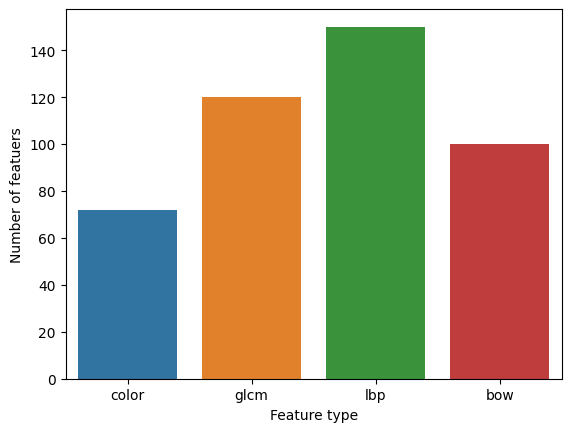

In [30]:
def check_subst_list(list_str, check_str):
    for l in list_str:
        if l in check_str:
            return True
    return False
from collections import defaultdict
feature_classes = {'color':[x for x in merged_df_train.columns if check_subst_list(['bgr', 'hsv', 'YCrCb'],x)],
                   'glcm':[x for x in merged_df_train.columns if check_subst_list(['contrast', 'dissimilarity',
                                                                                   'homogeneity', 'energy',
                                                                                   'correlation', 'ASM'], x)], 
                   'lbp': [x for x in merged_df_train.columns if 'lbp' in x], 
                   'bow':[x for x in merged_df_train.columns if 'bow' in x]}

feature_classes_inverted = {v:k for k,vv in feature_classes.items() for v in vv}

fi_res = Counter(merged_df_train.drop(columns=['class']).columns)
feature_importances_groupped = defaultdict(lambda: 0)
for fet, count in fi_res.items():
    feature_importances_groupped[feature_classes_inverted[fet]] += count
# normalize
feature_importances_groupped = {k:v for k,v in feature_importances_groupped.items()}
sns.barplot(x=list(feature_importances_groupped.keys()), y=list(feature_importances_groupped.values()))
plt.xlabel('Feature type')
plt.ylabel('Number of featuers')

In [25]:
feature_classes_inverted[fet]

KeyError: 'class'

In [28]:
merged_df_train

,bgr_b_mean,bgr_b_std,bgr_b_skew,bgr_b_kurt,bgr_b_max,bgr_b_min,bgr_b_entrp,bgr_b_unq,bgr_g_mean,bgr_g_std,...,bow_90,bow_91,bow_92,bow_93,bow_94,bow_95,bow_96,bow_97,bow_98,bow_99
name,,,,,,,,,,,,,,,,,,,,,
mel01589_inpaint_1.png,170.521469,14.279902,-1.169777,2.027095,213.0,86.0,12.502532,121,141.342224,21.211283,...,0.000000,0.221457,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
mel01256_inpaint_1.png,170.467880,51.064983,-0.671011,-0.957078,244.0,19.0,13.455862,224,156.943832,58.743664,...,0.067654,0.068785,0.0,0.107187,0.000000,0.000000,0.0,0.0,0.0,0.0
mel01264_inpaint_1.png,156.189102,18.423439,-1.775789,2.678466,181.0,45.0,13.848605,134,121.252441,22.936462,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
mel00486_inpaint_1.png,171.082581,24.427982,-1.068252,0.751099,236.0,27.0,13.564381,199,143.453659,37.366310,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
mel00530_inpaint_1.png,187.867966,22.217545,-1.693444,3.582002,252.0,45.0,13.603506,200,171.726898,29.892948,...,0.000000,0.069929,0.0,0.000000,0.000000,0.236103,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scc00022_inpaint_1.png,169.037491,18.246159,-0.614202,0.584457,218.0,92.0,13.507491,127,148.423157,29.574821,...,0.000000,0.000000,0.0,0.216593,0.000000,0.039108,0.0,0.0,0.0,0.0
scc00312_inpaint_1.png,193.106750,14.307260,-2.675153,13.725303,240.0,46.0,13.242448,195,153.268829,15.871718,...,0.000000,0.102649,0.0,0.000000,0.000000,0.057763,0.0,0.0,0.0,0.0
scc00368_inpaint_1.png,197.185593,18.616859,-0.910932,1.672383,241.0,10.0,12.501546,197,148.762634,24.890207,...,0.000000,0.240743,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
